# TODO LIST

- [ ] Choose Amsterdam / Rotterdam via parameter
- [ ] Add Lags for remaining districts
- [ ] Add / Replace Abs values with Diff values
- [ ] Look-ahead values (1min 5min 10min 30min) (tunable)
- [ ] Confusion Matrix per bin - find out model inaccuracies
- [ ] Add LightGBM model
- [ ] Benchmark accuracy, train-time, inference-time

ADD MORE DAYS OF DATA


In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_regression

In [19]:
df = pd.read_csv("data/processed/most_crowded.csv")

## 1. Feature Extraction

1. Binning
2. Time-related
   1. Extraction
      1. Hour
      2. Minute
      3. Day of week
   2. Cyclic Encoding
3. Lagged Features
   1. 1-10 Minutes
   2. 15 Minutes
   3. 30 Minutes
4. Rolling Mean Features
   1. Min
   2. Max
   3. Sum
   4. Mean
   5. Std


##### Binning


In [20]:
mean_crowd = df["crowd"].mean()
std_crowd = df["crowd"].std()

# Define bins based on mean and standard deviation
bins = [
    float("-inf"),
    mean_crowd - 1.0 * std_crowd,
    mean_crowd - 0.5 * std_crowd,
    mean_crowd + 0.5 * std_crowd,
    mean_crowd + 1.0 * std_crowd,
    float("inf"),
]

# Define labels for the bins
labels = list(range(len(bins) - 1))

In [21]:
for i in range(len(bins) - 1):
    print(
        f"No. of values in bin {i + 1}: {df['crowd'].between(bins[i], bins[i + 1]).sum()}"
    )

No. of values in bin 1: 124
No. of values in bin 2: 178
No. of values in bin 3: 362
No. of values in bin 4: 120
No. of values in bin 5: 135


In [22]:
c_lvl = pd.cut(
    df["crowd"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    ordered=True,
).astype(int)

In [23]:
# c_lvl = c_lvl.sub(c_lvl.shift().fillna(0)).astype(int)

df["c_lvl"] = c_lvl

In [24]:
ts_date = pd.to_datetime(df["timestamp"], unit="s")

# Time-related features
time_related_features = {
    "hour": ts_date.dt.hour.astype(int),
    "day_of_week": ts_date.dt.day_of_week.astype(int),
    "minute": ts_date.dt.minute.astype(int),
    "is_weekend": (ts_date.dt.weekday >= 5).astype(bool),
}

In [25]:
# Cyclical Encoding
def cyclic_encode(df: pd.DataFrame, col: str, period: int) -> pd.DataFrame:
    df[col + "_sin"] = np.sin(2 * np.pi * df[col] / period)
    df[col + "_cos"] = np.cos(2 * np.pi * df[col] / period)
    return df

In [26]:
# Lagged features
lags = list(range(1, 11)) + [15, 30]

lagged_features = {f"lag_{i}": df["crowd"].shift(i) for i in lags}


# Rolling features
rolling_features = {
    f"rolling_{stat}_{window}": getattr(df["crowd"].rolling(window=window), stat)()
    for window in [5, 10, 15, 30]
    for stat in ["mean", "std", "min", "max", "sum"]
}

#### Lagged and Rolling Mean Features


In [27]:
lagged_df = (
    df.assign(**time_related_features, **lagged_features, **rolling_features)
    .drop(columns="crowd")
    .set_index("timestamp")
    .dropna()
)


lagged_df.tail(10)

,c_lvl,hour,day_of_week,minute,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,...,rolling_mean_15,rolling_std_15,rolling_min_15,rolling_max_15,rolling_sum_15,rolling_mean_30,rolling_std_30,rolling_min_30,rolling_max_30,rolling_sum_30
timestamp,,,,,,,,,,,,,,,,,,,,,
1.713256e+09,4,8,1,30,False,194.0,214.0,229.0,239.0,255.0,...,222.200000,20.888137,194.0,266.0,3333.0,217.700000,18.416915,194.0,266.0,6531.0
1.713256e+09,4,8,1,32,False,219.0,194.0,214.0,229.0,239.0,...,223.200000,20.039960,194.0,266.0,3348.0,217.966667,18.299205,194.0,266.0,6539.0
1.713256e+09,4,8,1,33,False,214.0,219.0,194.0,214.0,229.0,...,223.600000,19.816299,194.0,266.0,3354.0,218.033333,18.287896,194.0,266.0,6541.0
1.713257e+09,3,8,1,35,False,216.0,214.0,219.0,194.0,214.0,...,223.400000,20.031404,194.0,266.0,3351.0,217.800000,18.451054,194.0,266.0,6534.0
1.713257e+09,4,8,1,37,False,202.0,216.0,214.0,219.0,194.0,...,224.266667,20.246575,194.0,266.0,3364.0,218.133333,18.674588,194.0,266.0,6544.0
1.713257e+09,4,8,1,39,False,235.0,202.0,216.0,214.0,219.0,...,225.800000,19.373030,194.0,266.0,3387.0,219.166667,18.202090,194.0,266.0,6575.0
1.713257e+09,4,8,1,41,False,226.0,235.0,202.0,216.0,214.0,...,229.266667,20.575529,194.0,266.0,3439.0,221.233333,19.207907,194.0,266.0,6637.0
1.713257e+09,4,8,1,43,False,260.0,226.0,235.0,202.0,216.0,...,230.600000,21.330059,194.0,266.0,3459.0,222.600000,19.829619,194.0,266.0,6678.0
1.713257e+09,4,8,1,45,False,251.0,260.0,226.0,235.0,202.0,...,230.200000,21.217244,194.0,266.0,3453.0,223.266667,19.831938,194.0,266.0,6698.0


In [28]:
lagged_df = cyclic_encode(lagged_df, "minute", 60)
lagged_df = cyclic_encode(lagged_df, "hour", 24)
lagged_df = cyclic_encode(lagged_df, "day_of_week", 7)

## 4. Model Building


In [29]:
X = lagged_df.drop(columns=["c_lvl"])
y = lagged_df["c_lvl"]

Feature Selection


In [30]:
import seaborn as sns

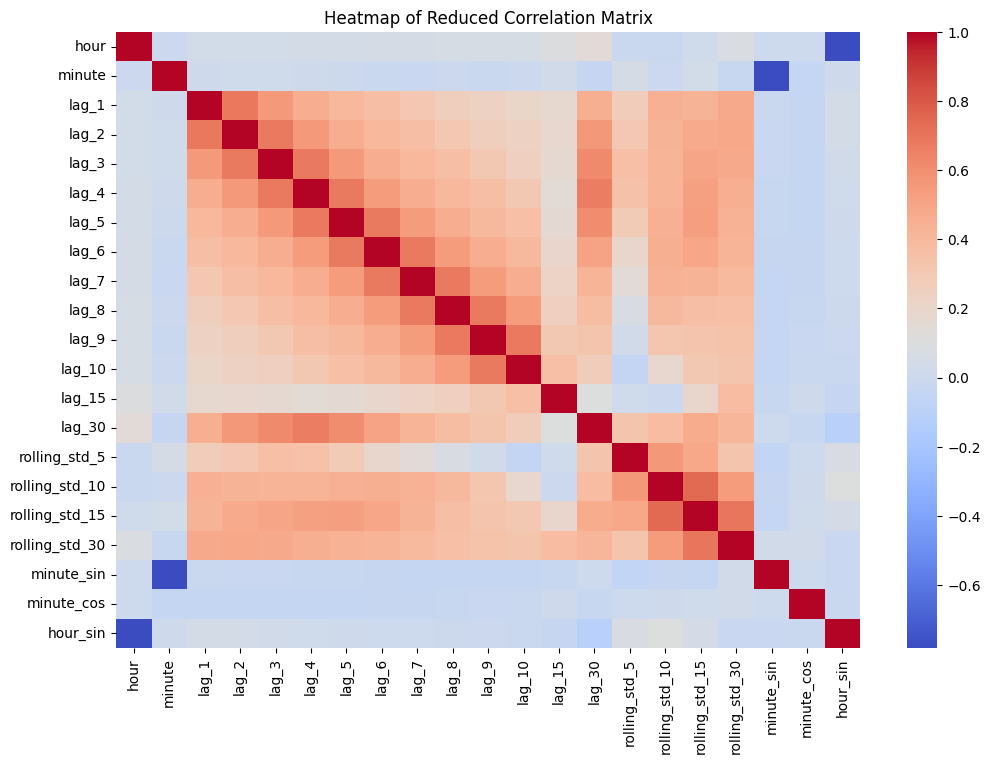

In [31]:
# Step 1: Correlation Analysis
cm = X.select_dtypes(exclude=bool).corr().abs()
upper = cm.where(np.triu(np.ones(cm.shape), k=1).astype(bool))

high_corr = [col for col in upper.columns if any(upper[col] > 0.8)]
X_reduced = X.drop(columns=high_corr)

plt.figure(figsize=(12, 8))
sns.heatmap(X_reduced.drop(
    columns=["is_weekend"]).corr(), annot=False, cmap="coolwarm")
plt.title("Heatmap of Reduced Correlation Matrix")
plt.show()

In [32]:
# Step 2: Univariate Feature Selection


selector = SelectKBest(score_func=f_regression, k=X_reduced.shape[1])
result = selector.fit_transform(X_reduced, y)

# Get the selected feature names
selected_features = X_reduced.columns[selector.get_support()]

# Visualize selected features
feature_scores = (
    pd.DataFrame(
        {
            "Feature": selected_features,
            "Score": selector.scores_[selector.get_support()],
        }
    )
    .sort_values(by="Score", ascending=False)
    .reset_index(drop=True)
)

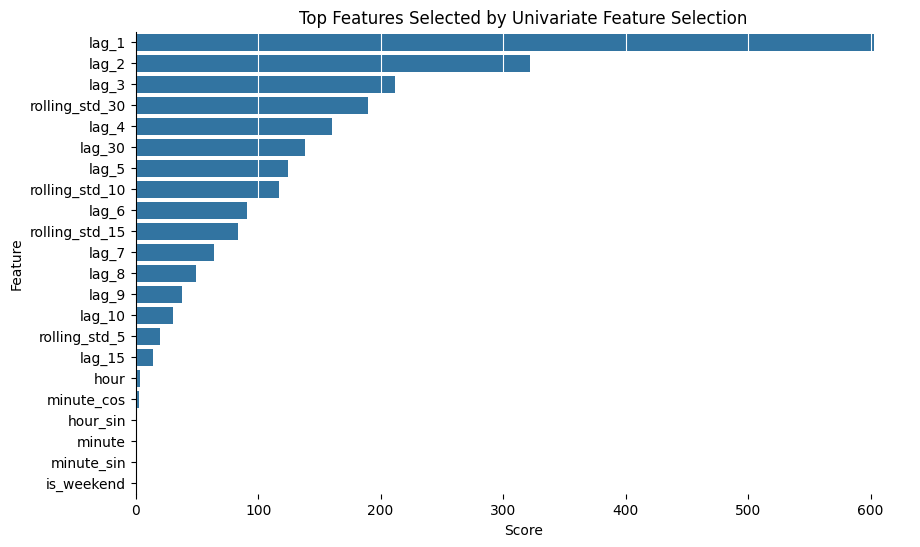

In [33]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Score", y="Feature", data=feature_scores)
plt.title("Top Features Selected by Univariate Feature Selection")
plt.grid(axis="x", color="white")
plt.gca().spines[["top", "right", "bottom"]].set_visible(False)
plt.show()

In [34]:
high_scorers = feature_scores.drop(index=feature_scores.iloc[11:, :].index)[
    "Feature"
].values.tolist()

X_reduced = X_reduced.loc[:, high_scorers]

In [35]:
X_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 1713176881.605811 to 1713257252.4110296
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lag_1           889 non-null    float64
 1   lag_2           889 non-null    float64
 2   lag_3           889 non-null    float64
 3   rolling_std_30  889 non-null    float64
 4   lag_4           889 non-null    float64
 5   lag_30          889 non-null    float64
 6   lag_5           889 non-null    float64
 7   rolling_std_10  889 non-null    float64
 8   lag_6           889 non-null    float64
 9   rolling_std_15  889 non-null    float64
 10  lag_7           889 non-null    float64
dtypes: float64(11)
memory usage: 83.3 KB


1. Pipeline Construction
2. Time Series Cross Validation


In [36]:
num_features = X_reduced.select_dtypes(
    include=[np.uint16, np.float64]).columns.tolist()

In [37]:
preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_features)], remainder="passthrough"
)

# Define the pipeline
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("estimator", XGBClassifier(n_estimators=100, random_state=42)),
    ]
)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'rolling_std_30', 'lag_4',
                                                   'lag_30', 'lag_5',
                                                   'rolling_std_10', 'lag_6',
                                                   'rolling_std_15',
                                                   'lag_7'])])),
                ('estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [38]:
param_grid = {
    "estimator__n_estimators": [50, 100, 200],
    "estimator__max_depth": [2, 3],
    "estimator__learning_rate": [0.01, 0.05, 0.1],
    "estimator__colsample_bytree": [0.5, 0.7, 0.8],
    "estimator__reg_lambda": [0.3, 0.5, 0.7],
}

In [39]:
ts_cv = TimeSeriesSplit(n_splits=5)

##### Grid Search


In [40]:
scoring = {
    "Accuracy": make_scorer(accuracy_score),
    "F1": make_scorer(f1_score, average="macro"),
}

In [41]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=ts_cv,
    scoring=scoring,
    refit="F1",
    n_jobs=1,
    verbose=1,
)
grid_search.fit(X_reduced, y)

print(f"Best score: {grid_search.best_score_:.3f}")
print(f"Best parameters:")
for key, value in grid_search.best_params_.items():
    print(f"    - {key.split('__')[-1]}: {value}")

cv_results = grid_search.cv_results_

Fitting 5 folds for each of 162 candidates, totalling 810 fits


KeyboardInterrupt: 

#### Best parameters from GridSearchCV:

- `colsample_bytree` = 0.5
- `learning_rate` = 0.1
- `max_depth` = 3
- `n_estimators` = 200
- `reg_lambda` = 0.5


In [ ]:
grid_search.best_estimator_["estimator"].feature_importances_

In [ ]:
cv_results = cross_validate(
    grid_search.best_estimator_,
    X_reduced,
    y,
    cv=ts_cv,
    scoring=scoring,
    n_jobs=1,
)

In [ ]:
for key, value in grid_search.cv_results_.items():
    if key.startswith("mean_test" or "test"):
        metric = key.split("_")[-1]
        print(f"{metric}: {value.mean():.3f} ± {value.std():.3f}")